<a href="https://colab.research.google.com/github/rajendranaidu495/ANLY699Project/blob/master/FinalProject_ANLY699_RajendraNaiduMannam_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

In [ ]:
#pip install pymagnitude==0.1.34
#!pip install pymagnitude

In [ ]:
#!pip install tensorflow-hub

In [ ]:
#import pymysql

#!pip install results

In [3]:
class TFHubExtract(object):
    def __init__(self, path="http://tfhub.dev/google/universal-sentence-encoder/4"):
        import tensorflow as tf
        import tensorflow_hub as hub
        # Create graph and finalize (finalizing optional but recommended).
        g = tf.Graph()
        with g.as_default():
            # We will be feeding 1D tensors of text into the graph.
            self.text_input = tf.placeholder(dtype=tf.string, shape=[None])
            embed = hub.Module(path)
            self.embedded_text = embed(self.text_input)
            init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
        g.finalize()
        self.session = tf.Session(graph=g)	
        self.session.run(init_op)

    def predict(self, x):
        return self.session.run(self.embedded_text, feed_dict={self.text_input: x})
    
    
class MeanEmbeddingVector(object):
    def __init__(self):
        from pymagnitude import Magnitude
        #self.model = Magnitude(r"C:\Users\rajendranaidu\Downloads\GoogleNews-vectors-negative300.magnitude")
        self.model = Magnitude("/content/sample_data/GoogleNews-vectors-negative300.magnitude")    

    def predict(self, X):
        return np.array([np.mean(self.model.query(x), axis=0) for x in X])

In [4]:
### read data
def read_df(filename):
    columns = ['sentiment','id','date','flag','user','text']
    df = pd.read_csv(filename,encoding='ISO-8859-1',names=columns)
    df = df[['text', 'sentiment']]
    return df

## pre-processing
def pre_process(df):
    ### tokenize text
    #df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x.lower()))
    df['text'] = df['text'].apply(lambda x: x.lower().split(' '))
    
    ## import nltk
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    
    ## apply stemming
    from nltk.stem.porter import PorterStemmer
    ps_stemmer = PorterStemmer()
    df['text'] = df['text'].apply(lambda x: [ps_stemmer.stem(y) for y in x])

    ## apply lemmatization
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer()
    df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
    

    ## covert tokenized words back to string
    #df['text'] = df['text'].apply(lambda x: ' '.join(x))
    
    return df

In [12]:
#df_all = pre_process(read_df(r"C:\Users\rajendranaidu\OneDrive - Harrisburg University\HU Courses\ANLY 699_90_O_2020Summer_ Applied Project in Analytics\FinalProject_ANLY699\training.csv"))
df_all = pre_process(read_df("/content/sample_data/training.csv"))

df = df_all.drop(df_all.index[50000:1550000])

### Train, Test splits
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['text'].tolist(), df['sentiment'].tolist(), test_size=0.3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
print(df.shape)

(100000, 2)


In [14]:
def get_features(x_train, x_test,type_='BOW'):
    if type_ == 'BOW':
        from sklearn.feature_extraction.text import TfidfVectorizer
        vect = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, stop_words='english', max_features=5000)
        vect.fit(x_train)
        X_train_BOW = vect.transform(x_train)
        X_test_BOW  = vect.transform(x_test)
        return X_train_BOW, X_test_BOW
    elif type_ == 'W2V':
        model = MeanEmbeddingVector()
        X_train_W2V = model.predict(x_train)
        X_test_W2V = model.predict(x_test)
        return X_train_W2V, X_test_W2V
    elif type_ == 'USE':
        #tfhub = TFHubExtract()
        x_train = [" ".join(x) for x in x_train]
        x_test = [" ".join(x) for x in x_test]
        import tensorflow_hub as hub

        embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        x_train_USE = embed(x_train)
        x_test_USE = embed(x_test)
        return x_train_USE,x_test_USE

In [15]:
def disc_model(x_train, x_test, y_train, y_test):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(max_iter=10000) 
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    import sklearn.metrics as metrics

    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    #print(metrics.accuracy_score(y_test, y_pred))

    
    import seaborn as sns
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [16]:
## Experiment
x_train_BOW, x_test_BOW = get_features(x_train, x_test)
#x_train_W2V, x_test_W2V = get_features(x_train, x_test, type_='W2V')
x_train_USE, x_test_USE = get_features(x_train, x_test, type_='USE')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


              precision    recall  f1-score   support

           0       0.77      0.73      0.75     15081
           4       0.74      0.78      0.76     14919

    accuracy                           0.76     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.76      0.76      0.76     30000



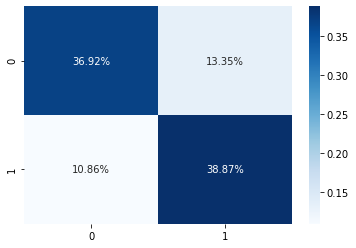

In [17]:
disc_model(x_train_BOW, x_test_BOW, y_train, y_test)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     15081
           4       0.76      0.76      0.76     14919

    accuracy                           0.76     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.76      0.76      0.76     30000



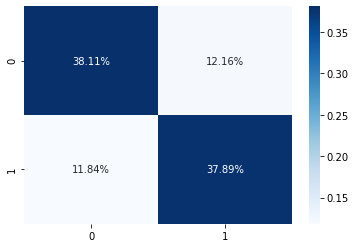

In [18]:
disc_model(x_train_USE, x_test_USE, y_train, y_test)